# Tests at the beginnig

In [236]:
import torch
import numpy as np
import matplotlib.pyplot as plt

dataset = []

# -----------------------------Completely unaligned bboxes
pred_bboxes = torch.tensor([
    [1, 1, 1, 1, 1, 1, 0],
    [3, 3, 3, 1, 1, 1, 0],
    [-2, -2, -2, 1, 1, 1, 0]
])
gt_bboxes = torch.tensor([
    [8, 8, 8, 1, 1, 1, 0],
    [-10, -10, -10, 1, 1, 1, 0],
])
dict = {}
dict['pred_bboxes'] = pred_bboxes
dict['gt_bboxes'] = gt_bboxes
dataset.append(dict)



dict1 = dict



# -----------------------------Not enough prediction bboxes (zero)
pred_bboxes = torch.tensor([])
gt_bboxes = torch.tensor([
    [8, 8, 8, 1, 1, 1, 0],
    [-10, -10, -10, 1, 1, 1, 0],
])
dict = {}
dict['pred_bboxes'] = pred_bboxes
dict['gt_bboxes'] = gt_bboxes
dataset.append(dict)



# -----------------------------Not enough prediction bboxes (just one with IoU=1)
pred_bboxes = torch.tensor([
    [8, 8, 8, 1, 1, 1, 0]
])
gt_bboxes = torch.tensor([
    [8, 8, 8, 1, 1, 1, 0],
    [-10, -10, -10, 1, 1, 1, 0],
])
dict = {}
dict['pred_bboxes'] = pred_bboxes
dict['gt_bboxes'] = gt_bboxes
dataset.append(dict)



# -----------------------------Completely aligned bboxes (and extra one)
pred_bboxes = torch.tensor([
    [8, 8, 8, 1, 1, 1, 0],
    [-10, -10, -10, 1, 1, 1, 0],
    [-2, -2, -2, 1, 1, 1, 0]
])
gt_bboxes = torch.tensor([
    [8, 8, 8, 1, 1, 1, 0],
    [-10, -10, -10, 1, 1, 1, 0],
])
dict = {}
dict['pred_bboxes'] = pred_bboxes
dict['gt_bboxes'] = gt_bboxes
dataset.append(dict)



# -----------------------------Completely aligned bboxes
pred_bboxes = torch.tensor([
    [8, 8, 8, 1, 1, 1, 0],
    [-10, -10, -10, 1, 1, 1, 0]
])
gt_bboxes = torch.tensor([
    [8, 8, 8, 1, 1, 1, 0],
    [-10, -10, -10, 1, 1, 1, 0],
])
dict = {}
dict['pred_bboxes'] = pred_bboxes
dict['gt_bboxes'] = gt_bboxes
dataset.append(dict)



# -----------------------------Partially aligned bboxes
pred_bboxes = torch.tensor([
    [8, 8, 8, 1, 1, 1, 0],
    [3, 3, 3, 1, 1, 1, 0],
    [-10, -10, -10, 1, 1, 1, 0]
])
gt_bboxes = torch.tensor([
    [8, 8, 8, 1, 1, 1, 0],
    [-10, -10, -10, 1, 1, 1, 0],
    [-3, 3, 3, 1, 1, 1, 0]
])
dict = {}
dict['pred_bboxes'] = pred_bboxes
dict['gt_bboxes'] = gt_bboxes
dataset.append(dict)



for i in range(10):
    dataset.append(dict1)

In [13]:
def plot_curve(precisions, recalls):
    # Plotting the precision-recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, marker='o', linestyle='-', color='b')
    
    # Set x and y axis limits from 0 to 1
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    
    # Adding labels, title, and grid
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    
    # Display the plot
    plt.show()

In [238]:
def iou_computer(box1, box2):
    """
    Computes the 3D IoU between two bounding boxes.
    Each box is defined as [x, y, z, dx, dy, dz, yaw].
    For simplicity, we will ignore the yaw for the IoU computation.
    """
    # Extract the dimensions of the boxes
    x1, y1, z1, dx1, dy1, dz1, _ = box1
    x2, y2, z2, dx2, dy2, dz2, _ = box2

    # Calculate the overlap in each dimension
    inter_x = max(0, min(x1 + dx1 / 2, x2 + dx2 / 2) - max(x1 - dx1 / 2, x2 - dx2 / 2))
    inter_y = max(0, min(y1 + dy1 / 2, y2 + dy2 / 2) - max(y1 - dy1 / 2, y2 - dy2 / 2))
    inter_z = max(0, min(z1 + dz1 / 2, z2 + dz2 / 2) - max(z1 - dz1 / 2, z2 - dz2 / 2))

    # Calculate the intersection volume
    inter_volume = inter_x * inter_y * inter_z

    # Calculate the volume of both boxes
    vol1 = dx1 * dy1 * dz1
    vol2 = dx2 * dy2 * dz2

    # Calculate the IoU
    iou = inter_volume / (vol1 + vol2 - inter_volume + 1e-10)
    return iou

In [239]:
def compute_precision_recall(pred_bboxes, gt_bboxes):
    # Initialize the number of true positives and false positives
    tp = 0
    fp = 0
    # Create a set (NO repetition!!) that tracks the indeces of matched ground truths
    matched_gts = set()

    # Many steps:
    #       - cycle through the predictions
    #       - then through the ground truths, to find the best match for the prediction
    #       - when (and if) best match has been found:
    #           - update the tp if over the iou_threshold and not already matched
    #           - otherwise update the fp
    for i in range(pred_bboxes.size(0)):
        # Initialize values
        best_iou = 0
        best_gt_idx = -1
        # Internal for loop
        for j in range(gt_bboxes.size(0)):
            iou = iou_computer(pred_bboxes[i].tolist(), gt_bboxes[j].tolist())
            # Check if the match has to be updated
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = j
        # Update tp or fp
        if best_iou >= 0.5 and best_gt_idx not in matched_gts:
            tp += 1
            matched_gts.add(best_gt_idx)
        else:
            fp += 1

    # False negatives are ground truths that were not matched
    fn = gt_bboxes.size(0) - len(matched_gts)

    # Calculate precision and recall, and return them
    precision = tp / (tp + fp + 1e-15)
    recall = tp / (tp + fn + 1e-15)
    return precision, recall

In [240]:
def compute_ap40(precisions, recalls):
    
    recall_levels = np.linspace(0, 1, 40)
    ap40 = 0.0

    for recall_level in recall_levels:
        # Find the highest precision for the recall level or below
        precisions_at_recall = precisions[recalls >= recall_level]
        if precisions_at_recall.size > 0:
            ap40 += np.max(precisions_at_recall)

    ap40 /= len(recall_levels)
    return ap40

0.0 	0.0
0.0 	0.0
0.9999 	0.4999
0.6666 	0.9999
0.9999 	0.9999
0.6666 	0.6666
0.0 	0.0
0.0 	0.0
0.0 	0.0
0.0 	0.0
0.0 	0.0
0.0 	0.0
0.0 	0.0
0.0 	0.0
0.0 	0.0
0.0 	0.0

-----------------------------------------------------------------------
The metric AP40 is: 0.024999999999999988


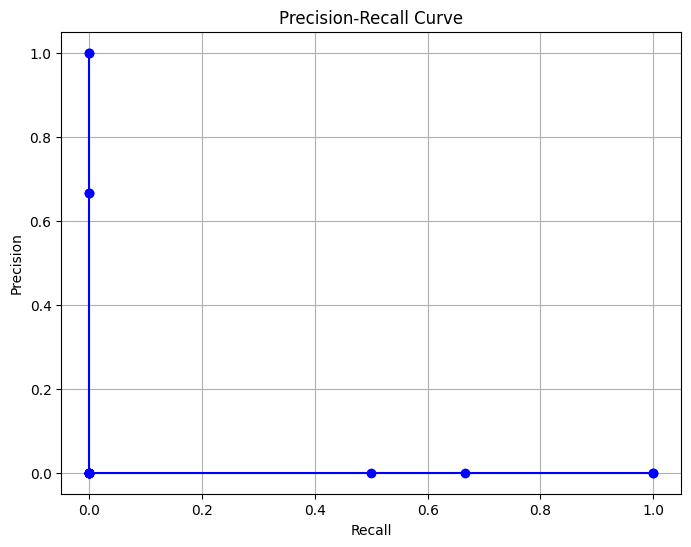

In [241]:
# Create empty lists for precision and recall
precisions = []
recalls = []


# Cycle through the dictionaries (one for each scan in the dataset)
for dict in dataset:
    # The bboxes come already sorted, so there's no need to sort them again
    pass
    # Compute the precision and recall for the scan
    precision, recall = compute_precision_recall(dict['pred_bboxes'], dict['gt_bboxes'])
    precisions.append(precision)
    recalls.append(recall)
    print("%s \t%s" %(str(precision)[:6], str(recall)[:6]))


# Aggregate all precision-recall curves into a single one
precisions = np.array(sorted(precisions, reverse=True))
recalls = np.array(sorted(recalls))

# Compute AP40
ap40 = compute_ap40(precisions, recalls)


print()
print("-----------------------------------------------------------------------")
print("The metric AP40 is: %s" %ap40)
plot_curve(precisions, recalls)


-----------------------------------------------------------------------
The metric AP40 is: 0.7579999999999999


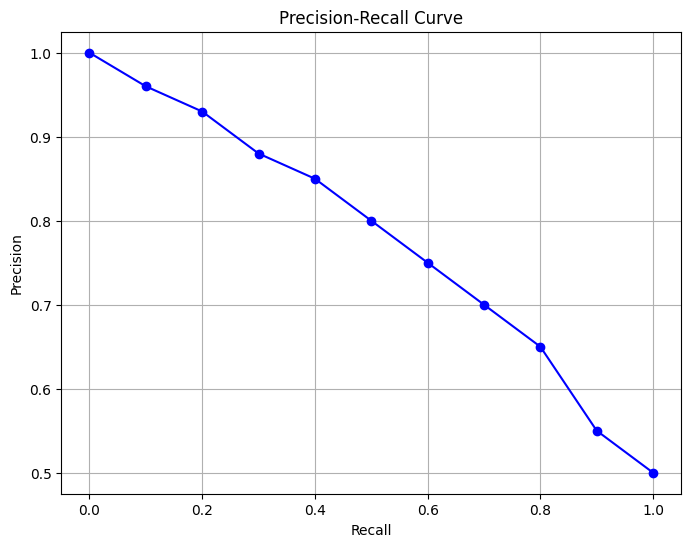

In [242]:
recalls = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
precisions = [1.0, 0.96, 0.93, 0.88, 0.85, 0.80, 0.75, 0.7, 0.65, 0.55, 0.5]


# Compute AP40
precisions = np.array(precisions)
recalls = np.array(recalls)
ap40 = compute_ap40(precisions, recalls)


print()
print("-----------------------------------------------------------------------")
print("The metric AP40 is: %s" %ap40)
plot_curve(precisions, recalls)

# plt.scatter(recall)

In [247]:
tensor1 = torch.Tensor(1, 7)
print(tensor1)

pred_bboxes = torch.tensor([
    [1, 1, 1, 1, 1, 1, 0],
    [3, 3, 3, 1, 1, 1, 0],
    [-2, -2, -2, 1, 1, 1, 0]
])
print(pred_bboxes[0])

tensor1[0] = pred_bboxes[0]
print(tensor1)
print(tensor1.dim())
print(tensor1.size(-1))


tensor([[5.7778e-33, 3.3474e-41, 4.5527e-34, 3.3474e-41, 4.4842e-44, 0.0000e+00,
         6.7262e-44]])
tensor([1, 1, 1, 1, 1, 1, 0])
tensor([[1., 1., 1., 1., 1., 1., 0.]])
2
7


# Just plot the curve and compute the AP40

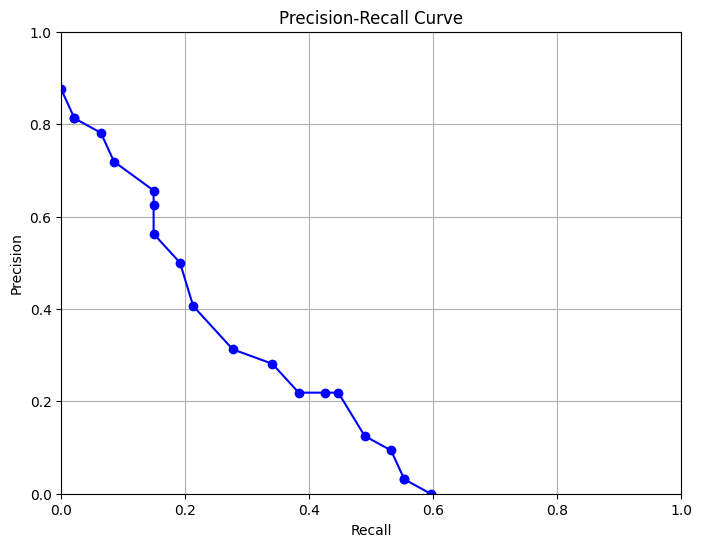

The AP40 value is: 0.21265243902439024


In [2]:
import numpy as np
import matplotlib.pyplot as plt


#################################################################################################################
#                                           Score_threshold = 0.3                                               #
#################################################################################################################


precisions = np.array(
    [0.875, 0.8125, 0.8125, 0.78125, 0.71875, 0.65625, 0.625, 0.5625, 0.5, 0.40625, 0.3125, 0.28125, 0.21875, 0.21875, 0.21875, 0.125, 0.09375, 0.03125, 0.03125, 0.0]
    )
recalls = np.array(
    [0.0, 0.02127659574468085, 0.02127659574468085, 0.06382978723404255, 0.0851063829787234, 0.14893617021276595, 0.14893617021276595, 0.14893617021276595, 0.19148936170212766, 0.2127659574468085, 0.2765957446808511, 0.3404255319148936, 0.3829787234042553, 0.425531914893617, 0.44680851063829785, 0.48936170212765956, 0.5319148936170213, 0.5531914893617021, 0.5531914893617021, 0.5957446808510638]
    )

# delta = 0.95-0.35
# print(delta)
# interval = 0.025
# number = round( delta / interval )
# print(number+1)
# test_delta = (number)*interval
# print(test_delta)

def plot_curve(precisions, recalls):
    # Plotting the precision-recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, marker='o', linestyle='-', color='b')
    
    # Set x and y axis limits from 0 to 1
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    
    # Adding labels, title, and grid
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    
    # Display the plot
    plt.show()

def compute_ap40(precisions, recalls):
    
    recall_levels = np.linspace(0, 1, 41)
    ap40 = 0.0

    for recall_level in recall_levels:
        # Find the highest precision for the recall level or below
        precisions_at_recall = precisions[recalls >= recall_level]
        if precisions_at_recall.size > 0:
            ap40 += np.max(precisions_at_recall)

    ap40 /= len(recall_levels)
    return ap40

plot_curve(precisions, recalls)
print(f"The AP40 value is: {compute_ap40(precisions, recalls)}")


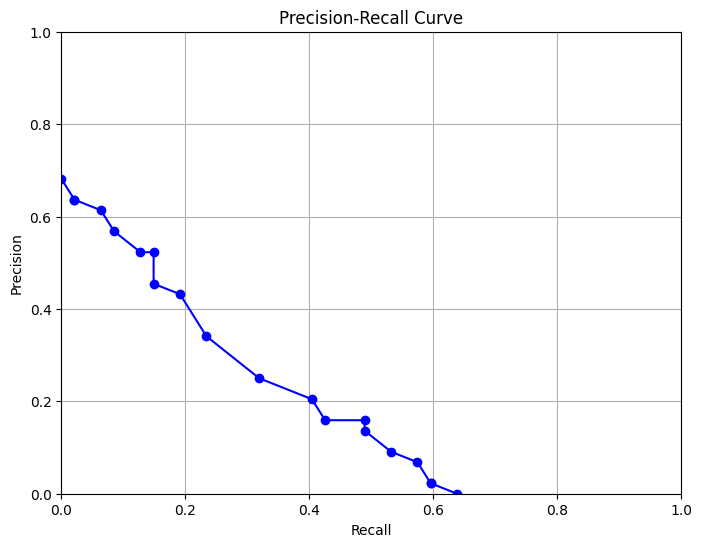

The AP40 value is: 0.17911791179117914


In [7]:
import numpy as np
import matplotlib.pyplot as plt


#################################################################################################################
#                                           Score_threshold = 0.05                                              #
#################################################################################################################


precisions = np.array(
    [0.6818181818181818, 0.6363636363636364, 0.6363636363636364, 0.6136363636363636, 0.5681818181818182, 0.5227272727272727, 0.5227272727272727, 0.45454545454545453, 0.4318181818181818, 0.3409090909090909, 0.25, 0.20454545454545456, 0.1590909090909091, 0.1590909090909091, 0.13636363636363635, 0.09090909090909091, 0.06818181818181818, 0.022727272727272728, 0.022727272727272728, 0.0]
    )
recalls = np.array(
    [0.0, 0.02127659574468085, 0.02127659574468085, 0.06382978723404255, 0.0851063829787234, 0.1276595744680851, 0.14893617021276595, 0.14893617021276595, 0.19148936170212766, 0.23404255319148937, 0.3191489361702128, 0.40425531914893614, 0.425531914893617, 0.48936170212765956, 0.48936170212765956, 0.5319148936170213, 0.574468085106383, 0.5957446808510638, 0.5957446808510638, 0.6382978723404256]
    )

# delta = 0.95-0.35
# print(delta)
# interval = 0.025
# number = round( delta / interval )
# print(number+1)
# test_delta = (number)*interval
# print(test_delta)

def plot_curve(precisions, recalls):
    # Plotting the precision-recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, marker='o', linestyle='-', color='b')
    
    # Set x and y axis limits from 0 to 1
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    
    # Adding labels, title, and grid
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    
    # Display the plot
    plt.show()

def compute_ap40(precisions, recalls):
    
    recall_levels = np.linspace(0, 1, 101)
    ap40 = 0.0

    for recall_level in recall_levels:
        # Find the highest precision for the recall level or below
        precisions_at_recall = precisions[recalls >= recall_level]
        if precisions_at_recall.size > 0:
            ap40 += np.max(precisions_at_recall)

    ap40 /= len(recall_levels)
    return ap40

plot_curve(precisions, recalls)
print(f"The AP40 value is: {compute_ap40(precisions, recalls)}")